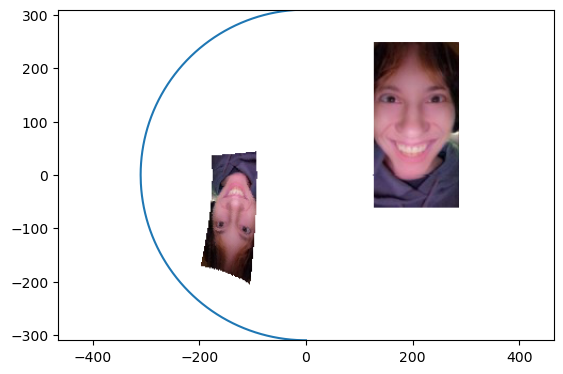

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

#Everything before "image = plt.imread(image)" is just on ellas request, before we actually submit it would be replaced
choice = "T"#input("Tall (T) or Wide (W)")
while choice.upper() != "T" and choice.upper() != "W":
    choice = input("Tall (T) or Wide (W)")
if choice.upper() == "T":
    ella_hugo_BOSS_ulbrich = randint(1,22)
    if ella_hugo_BOSS_ulbrich == 7:
        image = "Tall2.jpg"
        #Thales: 80 wide, 134 high
    else:
        image = "Tall1.jpg"
        #Ella: 80 wide, 155 high
else:
    image = "aWide.jpg"
    #164 wide, 80 high

image = plt.imread(image)
size = max(image.shape[0], image.shape[1]) * 2
canvas = np.zeros((size, int(size * 1.5), image.shape[2]), dtype=np.uint8)
canvas += 255
rad = int(2*image.shape[0])
start_x = int(0.8 * image.shape[1])
start_y = int(-0.8 * image.shape[0])

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        colour = image[y, x]
        old_x = x + start_x
        old_y = y + start_y

        denominator = rad**2 - old_x**2
        if denominator <= 0:
            continue
        theta = np.arctan(old_y / denominator**0.5)
        m = np.tan(2 * theta)

        numerator_part = (rad**2 - old_y**2)**0.5
        if numerator_part <= 0:
            continue
        numerator2 = -(m * numerator_part - old_y)
        denominator2 = (old_y / old_x) + m

        if denominator2 == 0:
            new_x = int(old_x*(-2*rad+denominator)/(2*old_x+denominator))
        else:
            new_x = int(numerator2 / denominator2)
        new_y = int(new_x * old_y / old_x)

        try:
            canvas[(size // 2) + old_y, (3 * size // 4) + old_x] = colour
        except:
            pass
        canvas[((size//2)+new_y), ((3*size//4)+new_x)] = colour
        #for dy in range(-1, 2):
        #    for dx in range(-1, 2):
        #        try:
        #            canvas[(size//2)+new_y+dy, (3*size//4)+new_x+dx] = colour
        #        except:
        #            continue

def generate_semicircle(center_x, center_y, radius, stepsize=0.1):
    x = np.arange(center_x, center_x+radius+stepsize, stepsize)
    y = np.sqrt(radius**2 - x**2)

    x = np.concatenate([x,x[::-1]])
    y = np.concatenate([y,-y[::-1]])

    return -x, y + center_y

x, y = generate_semicircle(0, 0, rad)
plt.imshow(canvas, extent=[-size * 1.5, size * 1.5, -size, size])
plt.xlim(-size * 1.5, size * 1.5)
plt.ylim(-size, size)
plt.plot(x,y)
plt.show()

Transforming 13120 object points...
Transformation complete.
Interpolating transformed image from 13120 valid points...
Interpolation complete.


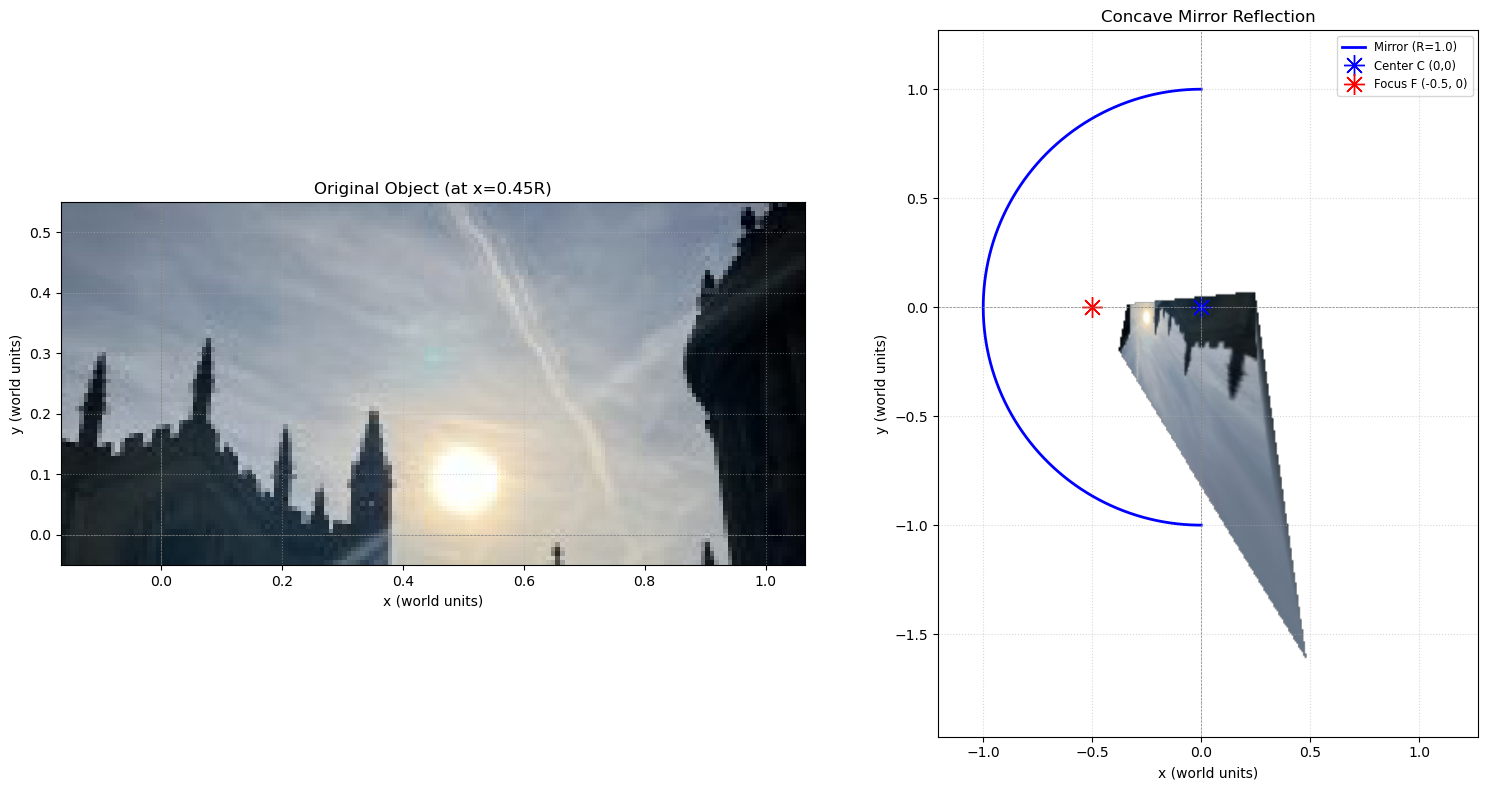

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
import matplotlib.path as mpath

# Function to transform object points (vectorized)
def transform_points_vectorized(x_o_flat, y_o_flat, R):
    """
    Transforms object points (x_o, y_o) to image points (x_i, y_i) for a concave mirror.
    Origin is at the Center of Curvature C. Pole V is at (-R,0). Focus F is at (-R/2,0).

    Args:
        x_o_flat (np.ndarray): Flattened array of object x-coordinates.
        y_o_flat (np.ndarray): Flattened array of object y-coordinates.
        R (float): Radius of curvature of the mirror.

    Returns:
        tuple (np.ndarray, np.ndarray): Flattened arrays of image x and y coordinates.
                                        NaNs indicate points that don't form a valid image.
    """
    # Initialize output arrays with NaNs
    x_i_flat = np.full_like(x_o_flat, np.nan)
    y_i_flat = np.full_like(y_o_flat, np.nan)

    if R <= 0: # Invalid radius
        return x_i_flat, y_i_flat

    # --- Pre-calculate masks for different cases ---
    # Valid y_o: ray parallel to axis must hit the mirror segment (-sqrt(R^2-y_o^2) exists)
    # R^2 - y_o^2 >= 0  => |y_o| <= R
    valid_y_mask = (R*R - y_o_flat**2) >= -1e-9 # Allow small float errors, effectively |y_o| <= R
    
    # Points at the Center of Curvature C(0,0)
    at_C_mask = np.isclose(x_o_flat, 0) & np.isclose(y_o_flat, 0) & valid_y_mask
    
    # Points on the principal axis (y_o approx 0), excluding C
    on_axis_mask = np.isclose(y_o_flat, 0) & ~at_C_mask & valid_y_mask
    
    # Points on the y-axis (x_o approx 0), excluding C and on_axis points
    on_yaxis_mask = np.isclose(x_o_flat, 0) & ~at_C_mask & ~on_axis_mask & valid_y_mask
    
    # General off-axis points: all others that have a valid y_o
    general_mask = ~at_C_mask & ~on_axis_mask & ~on_yaxis_mask & valid_y_mask

    # --- Case 1: Object at C (0,0) ---
    x_i_flat[at_C_mask] = 0
    y_i_flat[at_C_mask] = 0
    
    # --- Case 2: On principal axis (y_o approx 0), not at C ---
    if np.any(on_axis_mask):
        x_o_on_axis = x_o_flat[on_axis_mask]
        # Denominator for on-axis formula: R + 2*x_o
        den_on_axis = R + 2 * x_o_on_axis
        # Image at infinity if object at F (x_o = -R/2 => den_on_axis = 0)
        # Valid calculation where den_on_axis is not zero
        safe_calc_on_axis = ~np.isclose(den_on_axis, 0)
        
        x_i_calc = np.full_like(x_o_on_axis, np.nan)
        if np.any(safe_calc_on_axis):
            x_i_calc[safe_calc_on_axis] = -x_o_on_axis[safe_calc_on_axis] * R / den_on_axis[safe_calc_on_axis]
        
        x_i_flat[on_axis_mask] = x_i_calc
        y_i_flat[on_axis_mask] = 0

    # --- Case 3: On y-axis (x_o approx 0), not at C, y_o valid ---
    if np.any(on_yaxis_mask):
        y_o_on_yaxis = y_o_flat[on_yaxis_mask]
        
        val_sqrt_sq_yaxis = R*R - y_o_on_yaxis**2
        # Ensure sqrt argument is non-negative (already somewhat by valid_y_mask)
        sqrt_R2_y2_yaxis = np.sqrt(np.maximum(0, val_sqrt_sq_yaxis)) 
        
        # Denominator for y_i: R/2 - sqrt_R2_y2_yaxis
        den_yi_yaxis = R/2 - sqrt_R2_y2_yaxis
        # Image y at infinity if den_yi_yaxis is zero
        safe_calc_yaxis = ~np.isclose(den_yi_yaxis, 0)

        y_i_calc = np.full_like(y_o_on_yaxis, np.nan)
        if np.any(safe_calc_yaxis):
            y_i_calc[safe_calc_yaxis] = y_o_on_yaxis[safe_calc_yaxis] * (R/2) / den_yi_yaxis[safe_calc_yaxis]
            
        x_i_flat[on_yaxis_mask] = 0
        y_i_flat[on_yaxis_mask] = y_i_calc

    # --- Case 4: General off-axis points ---
    if np.any(general_mask):
        x_o_gen = x_o_flat[general_mask]
        y_o_gen = y_o_flat[general_mask]

        val_sqrt_sq_gen = R*R - y_o_gen**2
        sqrt_R2_y2_gen = np.sqrt(np.maximum(0, val_sqrt_sq_gen))

        # Denominator for x_i: (R/2 - sqrt_R2_y2_gen - x_o_gen)
        den_xi_gen = (R/2 - sqrt_R2_y2_gen - x_o_gen)
        # Image x_i at infinity if den_xi_gen is zero
        safe_calc_gen = ~np.isclose(den_xi_gen, 0)
        
        x_i_calc_gen = np.full_like(x_o_gen, np.nan)
        y_i_calc_gen = np.full_like(y_o_gen, np.nan)
        
        if np.any(safe_calc_gen):
            # Calculate x_i for valid denominators
            x_i_val = (x_o_gen[safe_calc_gen] * R/2) / den_xi_gen[safe_calc_gen]
            x_i_calc_gen[safe_calc_gen] = x_i_val
            
            # Calculate y_i. x_o_gen is confirmed non-zero by general_mask definition.
            y_i_calc_gen[safe_calc_gen] = (y_o_gen[safe_calc_gen] / x_o_gen[safe_calc_gen]) * x_i_val
        
        x_i_flat[general_mask] = x_i_calc_gen
        y_i_flat[general_mask] = y_i_calc_gen
        
    return x_i_flat, y_i_flat

def run_simulation():
    R = 1.0  # Radius of curvature

    # --- Load and Prepare Object Image ---
    try:
        # Using a readily available sample image from Matplotlib
        img_obj_data_rgba = mpimg.imread("aWide.jpg") # Example: 'logo.png' or 'grace_hopper.jpg'
    except FileNotFoundError:
        print("Sample image not found. Using a placeholder.")
        img_height, img_width = 60, 80 # Smaller placeholder for speed
        img_obj_data_rgba = np.zeros((img_height, img_width, 4), dtype=np.float32)
        # Create a simple pattern: Red L-shape
        img_obj_data_rgba[img_height//4 : 3*img_height//4, img_width//4 : img_width//2, 0] = 1 # Red
        img_obj_data_rgba[img_height//2 : 3*img_height//4, img_width//4 : 3*img_width//4, 0] = 1 # Red
        img_obj_data_rgba[img_height//4 : 3*img_height//4, img_width//4 : img_width//2, 1] = 0.5 # Some green
        img_obj_data_rgba[:,:,3] = 1 # Full alpha

    if img_obj_data_rgba.dtype == np.uint8:
        img_obj_data_rgba = img_obj_data_rgba / 255.0
    
    if img_obj_data_rgba.shape[2] == 3: # If RGB, add alpha channel
        img_obj_rgb = img_obj_data_rgba
        obj_alpha = np.ones((img_obj_rgb.shape[0], img_obj_rgb.shape[1]))
    elif img_obj_data_rgba.shape[2] == 4: # RGBA
        img_obj_rgb = img_obj_data_rgba[:,:,:3]
        obj_alpha = img_obj_data_rgba[:,:,3]
    else: # Grayscale or other, convert to RGB-like
        img_obj_rgb = np.stack((img_obj_data_rgba,)*3, axis=-1) if img_obj_data_rgba.ndim == 2 else img_obj_data_rgba[:,:,0:3]
        obj_alpha = np.ones((img_obj_rgb.shape[0], img_obj_rgb.shape[1]))


    # ... (inside run_simulation function)

    H_obj_img, W_obj_img = img_obj_rgb.shape[:2]

    # --- Object Placement in World Coordinates ---
    obj_world_height = 0.6 * R
    obj_world_width = (W_obj_img / H_obj_img) * obj_world_height if H_obj_img > 0 else 0.4*R

    obj_center_x = 0.45 * R
    obj_center_y = 0.25 * R

    # --- CORRECTED GRID CREATION ---
    # Create 1D vectors for the x and y coordinates that define the grid
    x_coords_obj_vec = np.linspace(obj_center_x - obj_world_width / 2,
                                   obj_center_x + obj_world_width / 2,
                                   W_obj_img)
    # The y-coordinates for the object. For imshow with origin='upper',
    # the image data's first row is at the 'top' of the extent.
    # So, y_coords_obj_vec should go from top y-value to bottom y-value.
    y_coords_obj_vec = np.linspace(obj_center_y + obj_world_height / 2, # Top y
                                   obj_center_y - obj_world_height / 2, # Bottom y
                                   H_obj_img)

    # Create 2D mesh grids
    # x_o_mesh will have shape (H_obj_img, W_obj_img)
    # y_o_mesh will have shape (H_obj_img, W_obj_img)
    x_o_mesh, y_o_mesh = np.meshgrid(x_coords_obj_vec, y_coords_obj_vec)

    # Flatten the 2D mesh grids to get 1D arrays of coordinates
    # Both x_o_flat and y_o_flat will now have shape (H_obj_img * W_obj_img,)
    x_o_flat = x_o_mesh.flatten()
    y_o_flat = y_o_mesh.flatten()
    # --- END OF CORRECTED GRID CREATION ---

    colors_r_flat = img_obj_rgb[:,:,0].flatten()
    colors_g_flat = img_obj_rgb[:,:,1].flatten()
    colors_b_flat = img_obj_rgb[:,:,2].flatten()
    alpha_flat = obj_alpha.flatten()

    # --- Transform Object Points to Image Points ---
    # Now len(x_o_flat) will be H_obj_img * W_obj_img
    print(f"Transforming {len(x_o_flat)} object points...")
    x_i_flat, y_i_flat = transform_points_vectorized(x_o_flat, y_o_flat, R)
# ... (rest of the function)
    print("Transformation complete.")

    valid_mask = ~np.isnan(x_i_flat) & ~np.isnan(y_i_flat) & (alpha_flat > 1e-3) # Consider transparent points invalid for image construction
    x_i_valid = x_i_flat[valid_mask]
    y_i_valid = y_i_flat[valid_mask]
    
    colors_r_valid = colors_r_flat[valid_mask]
    colors_g_valid = colors_g_flat[valid_mask]
    colors_b_valid = colors_b_flat[valid_mask]
    alpha_valid = alpha_flat[valid_mask] # Use alpha of valid points

    transformed_img_array = None
    grid_extent = None

    if len(x_i_valid) >= 3: # Need at least 3 points for griddata/triangulation
        print(f"Interpolating transformed image from {len(x_i_valid)} valid points...")
        
        padding_factor = 0.05 # Small padding
        x_min_valid, x_max_valid = x_i_valid.min(), x_i_valid.max()
        y_min_valid, y_max_valid = y_i_valid.min(), y_i_valid.max()

        x_range = x_max_valid - x_min_valid
        y_range = y_max_valid - y_min_valid

        # Handle cases where range is zero (e.g., all points collinear or single point)
        padding_x = max(x_range * padding_factor, 0.05 * R) 
        padding_y = max(y_range * padding_factor, 0.05 * R)

        grid_x_min, grid_x_max = x_min_valid - padding_x, x_max_valid + padding_x
        grid_y_min, grid_y_max = y_min_valid - padding_y, y_max_valid + padding_y
        grid_extent = [grid_x_min, grid_x_max, grid_y_min, grid_y_max]

        # Output resolution for the interpolated image
        # Aim for a resolution roughly proportional to the original image density in the transformed space
        transformed_width_world = grid_x_max - grid_x_min
        transformed_height_world = grid_y_max - grid_y_min
        
        # Heuristic for grid resolution
        density_x = W_obj_img / obj_world_width if obj_world_width > 0 else 100/R
        density_y = H_obj_img / obj_world_height if obj_world_height > 0 else 100/R
        
        grid_res_x = int(max(30, min(transformed_width_world * density_x, W_obj_img * 2.5))) # Cap resolution
        grid_res_y = int(max(30, min(transformed_height_world * density_y, H_obj_img * 2.5)))
        grid_res_x = max(grid_res_x,2) # Ensure at least 2 points for griddata
        grid_res_y = max(grid_res_y,2)


        grid_xi, grid_yi = np.meshgrid(
            np.linspace(grid_x_min, grid_x_max, grid_res_x),
            np.linspace(grid_y_min, grid_y_max, grid_res_y)
        )
        points_for_griddata = np.vstack((x_i_valid, y_i_valid)).T
        
        img_r_trans = griddata(points_for_griddata, colors_r_valid, (grid_xi, grid_yi), method='linear', fill_value=0)
        img_g_trans = griddata(points_for_griddata, colors_g_valid, (grid_xi, grid_yi), method='linear', fill_value=0)
        img_b_trans = griddata(points_for_griddata, colors_b_valid, (grid_xi, grid_yi), method='linear', fill_value=0)
        img_a_trans = griddata(points_for_griddata, alpha_valid, (grid_xi, grid_yi), method='linear', fill_value=0) # Interpolate alpha

        transformed_img_array = np.stack((img_r_trans, img_g_trans, img_b_trans, img_a_trans), axis=-1)
        transformed_img_array = np.clip(transformed_img_array, 0, 1)

        # Apply Convex Hull Mask
        try:
            if len(x_i_valid) >= 3:
                hull = ConvexHull(points_for_griddata)
                hull_path = mpath.Path(points_for_griddata[hull.vertices])
                grid_points_flat = np.vstack((grid_xi.flatten(), grid_yi.flatten())).T
                mask_in_hull = hull_path.contains_points(grid_points_flat).reshape(grid_xi.shape)
                transformed_img_array[:,:,3] *= mask_in_hull # Modulate alpha by hull mask
        except Exception as e:
            print(f"Could not compute or apply convex hull mask: {e}")
        print("Interpolation complete.")
    else:
        print("Not enough valid transformed points (<3) to create an interpolated image.")

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Original Object
    axs[0].imshow(np.concatenate((img_obj_rgb, obj_alpha[:,:,np.newaxis]), axis=2) if obj_alpha.ndim == 2 else img_obj_data_rgba, 
                  extent=[obj_center_x - obj_world_width/2, obj_center_x + obj_world_width/2,
                          obj_center_y - obj_world_height/2, obj_center_y + obj_world_height/2],
                  origin='upper', aspect='equal')
    axs[0].set_title(f"Original Object (at x={obj_center_x:.2f}R)")
    axs[0].set_xlabel("x (world units)")
    axs[0].set_ylabel("y (world units)")
    axs[0].axhline(0, color='gray', lw=0.5, linestyle='--')
    axs[0].axvline(0, color='gray', lw=0.5, linestyle='--')
    axs[0].grid(True, linestyle=':', alpha=0.5)
    axs[0].set_aspect('equal', 'box')


    # Plot 2: Mirror and Transformed Image
    ax_mirror = axs[1]
    mirror_angles = np.linspace(np.pi/2, 3*np.pi/2, 200)
    mirror_x = R * np.cos(mirror_angles)
    mirror_y = R * np.sin(mirror_angles)
    ax_mirror.plot(mirror_x, mirror_y, 'b-', lw=2, label=f"Mirror (R={R})")

    # Stars: (num_vertices, style:0=poly,1=star,2=thin star, angle)
    ax_mirror.plot(0, 0, marker=(8, 2, 0), markersize=15, color='blue', linestyle='None', label="Center C (0,0)")
    ax_mirror.plot(-R/2, 0, marker=(8, 2, 0), markersize=15, color='red', linestyle='None', label=f"Focus F (-{R/2}, 0)")

    if transformed_img_array is not None and grid_extent is not None:
        ax_mirror.imshow(transformed_img_array, 
                         extent=grid_extent,
                         origin='lower', interpolation='bilinear', aspect='equal')
    else:
        ax_mirror.text(0, 0, "Transformed image could not be generated.", 
                       ha='center', va='center', color='red', bbox=dict(facecolor='white', alpha=0.8))

    ax_mirror.set_title("Concave Mirror Reflection")
    ax_mirror.set_xlabel("x (world units)")
    ax_mirror.set_ylabel("y (world units)")
    ax_mirror.axhline(0, color='gray', lw=0.5, linestyle='--') # Principal axis
    ax_mirror.axvline(0, color='gray', lw=0.5, linestyle='--') # y-axis through C

    # Determine plot limits for the mirror view dynamically
    # Gather all relevant x and y coordinates that should be visible
    all_plot_x = np.concatenate((mirror_x, [0, -R/2, obj_center_x]))
    all_plot_y = np.concatenate((mirror_y, [0, 0, obj_center_y]))
    if x_i_valid is not None and len(x_i_valid) > 0:
        all_plot_x = np.concatenate((all_plot_x, x_i_valid))
        all_plot_y = np.concatenate((all_plot_y, y_i_valid))
    if grid_extent is not None:
        all_plot_x = np.concatenate((all_plot_x, [grid_extent[0], grid_extent[1]]))
        all_plot_y = np.concatenate((all_plot_y, [grid_extent[2], grid_extent[3]]))
    
    # Add object extent to ensure it's visible in the mirror plot if desired
    all_plot_x = np.concatenate((all_plot_x, [obj_center_x - obj_world_width/2, obj_center_x + obj_world_width/2]))
    all_plot_y = np.concatenate((all_plot_y, [obj_center_y - obj_world_height/2, obj_center_y + obj_world_height/2]))


    x_plot_min, x_plot_max = np.nanmin(all_plot_x), np.nanmax(all_plot_x)
    y_plot_min, y_plot_max = np.nanmin(all_plot_y), np.nanmax(all_plot_y)
    
    x_plot_range = x_plot_max - x_plot_min
    y_plot_range = y_plot_max - y_plot_min
    
    plot_margin_x = max(x_plot_range * 0.1, 0.2 * R)
    plot_margin_y = max(y_plot_range * 0.1, 0.2 * R)

    ax_mirror.set_xlim(x_plot_min - plot_margin_x, x_plot_max + plot_margin_x)
    ax_mirror.set_ylim(y_plot_min - plot_margin_y, y_plot_max + plot_margin_y)
    
    ax_mirror.set_aspect('equal', 'box')
    ax_mirror.legend(fontsize='small', loc='best')
    ax_mirror.grid(True, linestyle=':', alpha=0.5)

    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_simulation()

Transforming 12636 object corner points...
Transformation of corners complete.
Constructing 12400 polygons for the transformed image...
Added 12400 valid polygons to the plot.


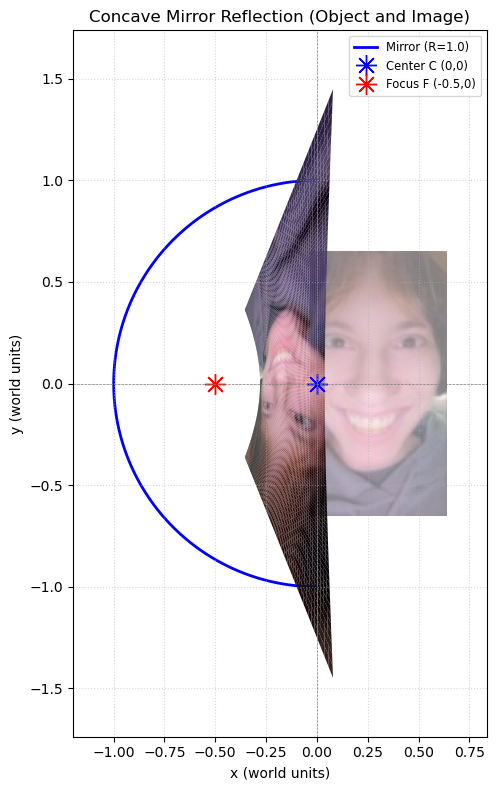

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

# Function to transform object points (vectorized) - unchanged
def transform_points_vectorized(x_o_flat, y_o_flat, R):
    x_i_flat = np.full_like(x_o_flat, np.nan)
    y_i_flat = np.full_like(y_o_flat, np.nan)
    if R <= 0: return x_i_flat, y_i_flat

    valid_y_mask = (R*R - y_o_flat**2) >= -1e-9
    at_C_mask = np.isclose(x_o_flat, 0) & np.isclose(y_o_flat, 0) & valid_y_mask
    on_axis_mask = np.isclose(y_o_flat, 0) & ~at_C_mask & valid_y_mask
    on_yaxis_mask = np.isclose(x_o_flat, 0) & ~at_C_mask & ~on_axis_mask & valid_y_mask
    general_mask = ~at_C_mask & ~on_axis_mask & ~on_yaxis_mask & valid_y_mask

    x_i_flat[at_C_mask] = 0
    y_i_flat[at_C_mask] = 0
    
    if np.any(on_axis_mask):
        x_o_on_axis = x_o_flat[on_axis_mask]
        den_on_axis = R + 2 * x_o_on_axis
        safe_calc_on_axis = ~np.isclose(den_on_axis, 0)
        x_i_calc = np.full_like(x_o_on_axis, np.nan)
        if np.any(safe_calc_on_axis):
            x_i_calc[safe_calc_on_axis] = -x_o_on_axis[safe_calc_on_axis] * R / den_on_axis[safe_calc_on_axis]
        x_i_flat[on_axis_mask] = x_i_calc
        y_i_flat[on_axis_mask] = 0

    if np.any(on_yaxis_mask):
        y_o_on_yaxis = y_o_flat[on_yaxis_mask]
        val_sqrt_sq_yaxis = R*R - y_o_on_yaxis**2
        sqrt_R2_y2_yaxis = np.sqrt(np.maximum(0, val_sqrt_sq_yaxis)) 
        den_yi_yaxis = R/2 - sqrt_R2_y2_yaxis
        safe_calc_yaxis = ~np.isclose(den_yi_yaxis, 0)
        y_i_calc = np.full_like(y_o_on_yaxis, np.nan)
        if np.any(safe_calc_yaxis):
            y_i_calc[safe_calc_yaxis] = y_o_on_yaxis[safe_calc_yaxis] * (R/2) / den_yi_yaxis[safe_calc_yaxis]
        x_i_flat[on_yaxis_mask] = 0
        y_i_flat[on_yaxis_mask] = y_i_calc

    if np.any(general_mask):
        x_o_gen = x_o_flat[general_mask]
        y_o_gen = y_o_flat[general_mask]
        val_sqrt_sq_gen = R*R - y_o_gen**2
        sqrt_R2_y2_gen = np.sqrt(np.maximum(0, val_sqrt_sq_gen))
        den_xi_gen = (R/2 - sqrt_R2_y2_gen - x_o_gen)
        safe_calc_gen = ~np.isclose(den_xi_gen, 0)
        x_i_calc_gen = np.full_like(x_o_gen, np.nan)
        y_i_calc_gen = np.full_like(y_o_gen, np.nan)
        if np.any(safe_calc_gen):
            x_i_val = (x_o_gen[safe_calc_gen] * R/2) / den_xi_gen[safe_calc_gen]
            x_i_calc_gen[safe_calc_gen] = x_i_val
            y_i_calc_gen[safe_calc_gen] = (y_o_gen[safe_calc_gen] / x_o_gen[safe_calc_gen]) * x_i_val
        x_i_flat[general_mask] = x_i_calc_gen
        y_i_flat[general_mask] = y_i_calc_gen
        
    return x_i_flat, y_i_flat

def run_simulation():
    R = 1.0  # Radius of curvature

    # --- Load and Prepare Object Image ---
    try:
        img_obj_data_rgba = mpimg.imread('Tall1.jpg') # User specified image
    except FileNotFoundError:
        print("Image 'Tall1.jpg' not found. Using a placeholder.")
        img_height, img_width = 60, 80
        img_obj_data_rgba = np.zeros((img_height, img_width, 4), dtype=np.float32)
        img_obj_data_rgba[img_height//4 : 3*img_height//4, img_width//4 : img_width//2, 0] = 1
        img_obj_data_rgba[img_height//2 : 3*img_height//4, img_width//4 : 3*img_width//4, 0] = 1
        img_obj_data_rgba[img_height//4 : 3*img_height//4, img_width//4 : img_width//2, 1] = 0.5
        img_obj_data_rgba[:,:,3] = 1

    if img_obj_data_rgba.dtype == np.uint8:
        img_obj_data_rgba = img_obj_data_rgba / 255.0
    
    if img_obj_data_rgba.shape[2] == 3:
        img_obj_rgb = img_obj_data_rgba
        obj_alpha_channel = np.ones((img_obj_rgb.shape[0], img_obj_rgb.shape[1]))
    elif img_obj_data_rgba.shape[2] == 4:
        img_obj_rgb = img_obj_data_rgba[:,:,:3]
        obj_alpha_channel = img_obj_data_rgba[:,:,3]
    else:
        img_obj_rgb = np.stack((img_obj_data_rgba,)*3, axis=-1) if img_obj_data_rgba.ndim == 2 else img_obj_data_rgba[:,:,0:3]
        obj_alpha_channel = np.ones((img_obj_rgb.shape[0], img_obj_rgb.shape[1]))

    H_obj_img, W_obj_img = img_obj_rgb.shape[:2]

    # --- Object Placement in World Coordinates ---
    obj_world_height = 1.3 * R 
    obj_world_width = (W_obj_img / H_obj_img) * obj_world_height if H_obj_img > 0 else 0.4*R
    
    obj_center_x = 0.3 * R # Object to the right of C, similar to user's example
    # obj_center_x = -0.75 * R # Object between F and V
    obj_center_y = 0.0 

    # --- Create grid of OBJECT PIXEL CORNERS ---
    # (H_obj_img+1) x (W_obj_img+1) grid of corner points
    x_obj_corner_coords_vec = np.linspace(obj_center_x - obj_world_width / 2,
                                          obj_center_x + obj_world_width / 2,
                                          W_obj_img + 1)
    y_obj_corner_coords_vec = np.linspace(obj_center_y + obj_world_height / 2, # Top y
                                          obj_center_y - obj_world_height / 2, # Bottom y
                                          H_obj_img + 1)

    x_o_corners_mesh, y_o_corners_mesh = np.meshgrid(x_obj_corner_coords_vec, y_obj_corner_coords_vec)
    
    x_o_corners_flat = x_o_corners_mesh.flatten()
    y_o_corners_flat = y_o_corners_mesh.flatten()

    # --- Transform Object Pixel Corner Points to Image Points ---
    print(f"Transforming {len(x_o_corners_flat)} object corner points...")
    x_i_corners_flat, y_i_corners_flat = transform_points_vectorized(x_o_corners_flat, y_o_corners_flat, R)
    print("Transformation of corners complete.")

    x_i_corners_mesh = x_i_corners_flat.reshape(H_obj_img + 1, W_obj_img + 1)
    y_i_corners_mesh = y_i_corners_flat.reshape(H_obj_img + 1, W_obj_img + 1)

    # --- Prepare for Plotting ---
    fig, ax = plt.subplots(1, 1, figsize=(10, 8)) # Single plot

    # Plot 1: Original Object (semi-transparent)
    obj_extent = [obj_center_x - obj_world_width/2, obj_center_x + obj_world_width/2,
                  obj_center_y - obj_world_height/2, obj_center_y + obj_world_height/2]
    
    ax.imshow(np.concatenate((img_obj_rgb, obj_alpha_channel[:,:,np.newaxis]), axis=2), 
              extent=obj_extent,
              origin='upper', aspect='auto', alpha=0.5, zorder=1) # auto aspect for obj

    # Plot 2: Mirror and Transformed Image using PatchCollection
    mirror_angles = np.linspace(np.pi/2, 3*np.pi/2, 200)
    mirror_x = R * np.cos(mirror_angles)
    mirror_y = R * np.sin(mirror_angles)
    ax.plot(mirror_x, mirror_y, 'b-', lw=2, label=f"Mirror (R={R})", zorder=0)

    ax.plot(0, 0, marker=(8, 2, 0), markersize=15, color='blue', linestyle='None', label="Center C (0,0)", zorder=2)
    ax.plot(-R/2, 0, marker=(8, 2, 0), markersize=15, color='red', linestyle='None', label=f"Focus F (-{R/2},0)", zorder=2)

    patches = []
    facecolors = []
    
    print(f"Constructing {H_obj_img * W_obj_img} polygons for the transformed image...")
    for r_idx in range(H_obj_img):
        for c_idx in range(W_obj_img):
            # Corners of the current cell in image space
            # Order: bottom-left, bottom-right, top-right, top-left (for polygon)
            # Or: v00, v01, v11, v10
            v00 = (x_i_corners_mesh[r_idx,   c_idx],   y_i_corners_mesh[r_idx,   c_idx])
            v01 = (x_i_corners_mesh[r_idx,   c_idx+1], y_i_corners_mesh[r_idx,   c_idx+1])
            v11 = (x_i_corners_mesh[r_idx+1, c_idx+1], y_i_corners_mesh[r_idx+1, c_idx+1])
            v10 = (x_i_corners_mesh[r_idx+1, c_idx],   y_i_corners_mesh[r_idx+1, c_idx])
            
            polygon_verts = [v00, v01, v11, v10]

            # Only add polygon if all vertices are valid (not NaN)
            if not any(np.isnan(v[0]) or np.isnan(v[1]) for v in polygon_verts):
                patches.append(Polygon(polygon_verts, closed=True))
                color = img_obj_rgb[r_idx, c_idx]
                alpha = obj_alpha_channel[r_idx, c_idx]
                facecolors.append((color[0], color[1], color[2], alpha))
    
    if patches:
        collection = PatchCollection(patches, match_original=False, zorder=1) # match_original=False for individual facecolors
        collection.set_facecolor(facecolors)
        collection.set_edgecolor('none') # No visible edges for pixels
        ax.add_collection(collection)
        print(f"Added {len(patches)} valid polygons to the plot.")
    else:
        print("No valid polygons to draw for the transformed image.")


    ax.set_title("Concave Mirror Reflection (Object and Image)")
    ax.set_xlabel("x (world units)")
    ax.set_ylabel("y (world units)")
    ax.axhline(0, color='gray', lw=0.5, linestyle='--') 
    ax.axvline(0, color='gray', lw=0.5, linestyle='--') 

    # Determine plot limits dynamically
    all_plot_x = np.concatenate((mirror_x, [0, -R/2], x_obj_corner_coords_vec))
    all_plot_y = np.concatenate((mirror_y, [0, 0], y_obj_corner_coords_vec))
    
    valid_x_i_corners = x_i_corners_mesh[~np.isnan(x_i_corners_mesh)]
    valid_y_i_corners = y_i_corners_mesh[~np.isnan(y_i_corners_mesh)]

    if len(valid_x_i_corners) > 0:
        all_plot_x = np.concatenate((all_plot_x, valid_x_i_corners))
    if len(valid_y_i_corners) > 0:
        all_plot_y = np.concatenate((all_plot_y, valid_y_i_corners))
    
    if len(all_plot_x) > 0 and len(all_plot_y) > 0 : # Check if there are any points to plot
        x_plot_min, x_plot_max = np.nanmin(all_plot_x), np.nanmax(all_plot_x)
        y_plot_min, y_plot_max = np.nanmin(all_plot_y), np.nanmax(all_plot_y)
        
        x_plot_range = x_plot_max - x_plot_min if not np.isclose(x_plot_max,x_plot_min) else 1.0
        y_plot_range = y_plot_max - y_plot_min if not np.isclose(y_plot_max,y_plot_min) else 1.0
        
        plot_margin_x = max(x_plot_range * 0.1, 0.2 * R)
        plot_margin_y = max(y_plot_range * 0.1, 0.2 * R)

        ax.set_xlim(x_plot_min - plot_margin_x, x_plot_max + plot_margin_x)
        ax.set_ylim(y_plot_min - plot_margin_y, y_plot_max + plot_margin_y)
    else: # Default limits if no points
        ax.set_xlim(-1.5*R, 1.5*R)
        ax.set_ylim(-1.5*R, 1.5*R)

    ax.set_aspect('equal', 'box')
    ax.legend(fontsize='small', loc='best')
    ax.grid(True, linestyle=':', alpha=0.5)

    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_simulation()